In [1]:
import numpy as np
import pandas as pd
from pandas import datetime
import math
from tensorflow.contrib.rnn import LSTMCell

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import gc
%matplotlib inline

In [2]:
data = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")
data.index = data.apply(lambda x:datetime(x.year, x.month, x.day, x.hour), axis=1)

data.drop(columns=["year", "month", "day", "hour"], inplace=True)
data.rename(columns={"pm2.5":"pm25"}, inplace=True)
data = data[data["pm25"].isna() == False]
data = pd.concat([data, pd.get_dummies(data.cbwd)], axis=1)
data.drop(columns=["cbwd", "No"], inplace=True)
ts = pd.date_range(start=data.index.min(), end=data.index.max(), freq="H")
data = data.reindex(index=ts, method="pad")

In [3]:
data.pm25 = data.pm25.shift(-1)
data = data[data["pm25"].isna() == False]

In [4]:
Y = data.pm25.values
X = data.drop(columns="pm25").values
del data
gc.collect()

35

In [5]:
time_steps = 24

#Here we take into consideration the time_steps
size_of_test = X.shape[0]//10
size_of_train = X.shape[0] - X.shape[0]//10
size_of_test = size_of_test + size_of_train%time_steps -1
size_of_train = X.shape[0] - size_of_test
cut_off = size_of_train - 1

X_train, Y_train = X[0:cut_off,:], Y[0:cut_off]
X_test, Y_test = X[cut_off:,:], Y[cut_off::]
X_min, X_max = np.min(X_train, axis=0), np.max(X_train, axis=0)
X_train = (X_train-X_min)/(X_max-X_min)
X_test = (X_test-X_min)/(X_max-X_min)

assert(np.all(np.max(X_train, axis=0) == 1.0))
assert(np.all(np.min(X_train, axis=0) == 0.0))

print("X_train shape: {} ----- Y_train shape: {}-------".format(X_train.shape, Y_train.shape))

X_train shape: (39408, 10) ----- Y_train shape: (39408,)-------


In [6]:
def create_set_with_timestep(X, Y, time_steps):
    X_with_t = np.zeros((X.shape[0] - time_steps, time_steps, X.shape[1]))
    Y_with_t = np.zeros((Y.shape[0] - time_steps))
    
    for i in range(X_with_t.shape[0]):
        to_i = i + time_steps
        if to_i >= X.shape[0]:
            break;
        X_with_t[i,...] = np.vstack(X[i:to_i,:])
        Y_with_t[i,...] = Y[to_i-1]
    return (X_with_t, Y_with_t)
    
    

In [7]:
X_train_v = X_train[0:50, :]
Y_train_v = Y_train[0:50]
X_train_ut, Y_train_ut = create_set_with_timestep(X_train_v, Y_train_v, time_steps)

assert(np.all(X_train_ut[25,0,:] == X_train_v[25,:]))
assert(Y_train_ut[24] == Y_train_v[47])

del X_train_ut, X_train_v
gc.collect()

304

In [8]:
X_train, Y_train = create_set_with_timestep(X_train, Y_train, time_steps)
X_test, Y_test = create_set_with_timestep(X_test, Y_test, time_steps)

print("X_train shape {} --- Y_train shape {}\nX_test shape {} --- Y_test shape {}".
      format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

X_train shape (39384, 24, 10) --- Y_train shape (39384,)
X_test shape (4367, 24, 10) --- Y_test shape (4367,)


## Development in Tensorflow

In [27]:
graph = tf.Graph()
X_shape = X_train.shape
Y_shape = Y_train.shape
num_units = 40
batch_size = 50
with graph.as_default():
    X = tf.placeholder(shape=[batch_size, X_shape[1], X_shape[2]], dtype=tf.float32)
    Y = tf.placeholder(shape=[batch_size], dtype=tf.float32)
    #I do a basic now and look at the graph
    lstm_cell = LSTMCell(num_units=num_units)
    initial_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)
    outputs, state = tf.nn.(lstm_cell, inputs=X, initial_state=initial_state)
    
    init = tf.global_variables_initializer()
with tf.Session(graph=graph) as sess:
    sess.run(init)
    saver = tf.summary.FileWriter(logdir="log", graph=graph)
    saver.flush()
    
    
    
    

TypeError: raw_rnn() got an unexpected keyword argument 'inputs'

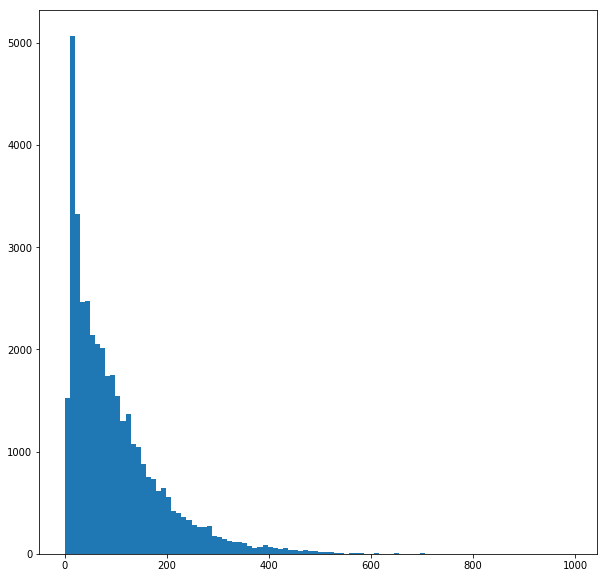